# Exercise 4
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU.

In [1]:
import os
import sys
import copy
import zipfile
import time
import random
import collections
import numpy as np
from PIL import Image
import pickle
import requests

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

import torchvision
import torchvision.transforms as T
import torchvision.models as models

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

print(torch.__version__)

%load_ext autoreload
%autoreload 2

2.0.1


# Recurrent Neural Networks (40 points)

Understanding and implementing the RNN cell. As you learned in class, the RNN has a certain structure that allows it to accept the previous hidden state the current input, and output an hidden state and an output vector. The RNN cell uses the same weights for all time steps, much like convolution uses the same weights for all the batches in the image. Even though you already are familiar with PyTorch, implementing the RNN you make sure you understand how this pivotal architecture works.

## Helper functions

In [2]:
def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

#  RNN: step forward (10 points)

First implement the function `rnn_step_forward` which implements the forward pass for a single timestep of a recurrent neural network. After doing so run the following to check your implementation. You should see errors less than 1e-7.

In [3]:
def rnn_step_forward(x, prev_h, Wx, Wh, b):
    """
    Run the forward pass for a single timestep of an RNN that uses a tanh
    activation function.

    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.

    Inputs:
    - x: Input data for this timestep, of shape (N, D).
    - prev_h: Hidden state from previous timestep, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - cache: Tuple of values needed for the backward pass.
    """
    next_h, cache = None, None
    ##############################################################################
    # TODO: Implement a single forward step for the RNN. Store the next  #
    # hidden state and any values you need for the backward pass in the next_h   #
    # and cache variables respectively.                                          #
    ##############################################################################

    # Calculate the affine transformation
    affine_output = np.dot(x, Wx) + np.dot(prev_h, Wh) + b

    # Activate the tanh function
    next_h = np.tanh(affine_output)

    cache = (x.copy(), prev_h.copy(), Wx.copy(), Wh.copy(), b.copy())

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return next_h, cache

In [4]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


#RNN: step backward (10 points)

In [5]:
def rnn_step_backward(dnext_h, cache):
    """
    Backward pass for a single timestep of an RNN.

    Inputs:
    - dnext_h: Gradient of loss with respect to next hidden state
    - cache: Cache object from the forward pass

    Returns a tuple of:
    - dx: Gradients of input data, of shape (N, D)
    - dprev_h: Gradients of previous hidden state, of shape (N, H)
    - dWx: Gradients of input-to-hidden weights, of shape (D, H)
    - dWh: Gradients of hidden-to-hidden weights, of shape (H, H)
    - db: Gradients of bias vector, of shape (H,)
    """
    dx, dprev_h, dWx, dWh, db = None, None, None, None, None
    ##############################################################################
    # TODO: Implement the backward pass for a single step of a RNN.      #
    #                                                                            #
    # HINT: For the tanh function, you can compute the local derivative in terms #
    # of the output value from tanh.                                             #
    ##############################################################################

    # Define the matrices from the forward
    x, prev_h, Wx, Wh, b = cache

    # Compute the derivatives

    # dtanh for the chain rule, of shape (N,H)
    dtanh = (1 - np.square(np.tanh(x @ Wx + prev_h @ Wh + b))) * dnext_h

    # (N,H) @ (H,D)
    dx = dtanh @ Wx.T

    # (N,H) @ (H,H)
    dprev_h = dtanh @ Wh.T

    # (D,N) @ (N,H)
    dWx = x.T @ dtanh

    # (H,N) @ (N,H)
    dWh = prev_h.T @ dtanh

    db = np.sum(dtanh, axis=0)

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return dx, dprev_h, dWx, dWh, db

In [6]:
np.random.seed(1337)
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  3.2389924368419153e-10
dprev_h error:  1.998548787839473e-08
dWx error:  8.09329219849245e-10
dWh error:  9.131782428817678e-10
db error:  6.240559767218964e-10


# RNN: forward (10 points)
Now that you have implemented the forward and backward passes for a single timestep of an RNN, you will combine these pieces to implement an RNN that process an entire sequence of data.

In [7]:
def rnn_forward(x, h0, Wx, Wh, b):
    """
    Run an RNN forward on an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The RNN uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the RNN forward, we return the hidden states for all timesteps.

    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D).
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - h: Hidden states for the entire timeseries, of shape (N, T, H).
    - cache: Values needed in the backward pass
    """
    h, cache = None, None
    ##############################################################################
    # TODO: Implement forward pass for a RNN running on a sequence of    #
    # input data. You should use the rnn_step_forward function that you defined  #
    # above. You can use a for loop to help compute the forward pass.            #
    ##############################################################################

    # Unpack the dimensions of x and h
    N, T, D = x.shape

    H = h0.shape[1]

    # Create an empty tensor of hidden states
    h = np.zeros((N, T, H))

    # Create an empty list of chaches
    cache = []

    # Assign the first hidden state
    prev_h = h0.copy()

    # Iterate over the T minibatches of sequences (N*D)
    for t, x_t in enumerate(x.transpose(1,0,2)):

      # Forward pass
      next_h, cur_cache = rnn_step_forward(x_t, prev_h, Wx, Wh, b)

      # Insert the hiddent state to h
      h[:,t,:] = next_h

      # Append the cache
      cache.append(cur_cache)

      # Update the previous h
      prev_h = next_h

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return h, cache

In [8]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.728466151011529e-08


# RNN: backward (10 points)

In [9]:
def rnn_backward(dh, cache):
    """
    Compute the backward pass for an RNN over an entire sequence of data.

    Inputs:
    - dh: Upstream gradients of all hidden states, of shape (N, T, H)

    Returns a tuple of:
    - dx: Gradient of inputs, of shape (N, T, D)
    - dh0: Gradient of initial hidden state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, H)
    - db: Gradient of biases, of shape (H,)
    """
    dx, dh0, dWx, dWh, db = None, None, None, None, None
    ##############################################################################
    # TODO: Implement the backward pass for a RNN running an entire      #
    # sequence of data. You should use the rnn_step_backward function that you   #
    # defined above. You can use a for loop to help compute the backward pass.   #
    ##############################################################################

    # Unpack the last cache items from the last hidden layer
    # x, prev_h, Wx, Wh, b = cache[-1]
    x, _, _, _, _ = cache[-1]

    # Unpack the dimensions of dh and x
    N, T, H = dh.shape

    D = x.shape[1]

    # Create an empty derivatives
    dx = np.zeros((N, T, D))

    cur_dprev_h = np.zeros((N, H))

    dWx = np.zeros((D, H))

    dWh = np.zeros((H, H))

    db = np.zeros((H,))

    # Iterate over the T hiddenstates (N*H)
    for t, dh_t in reversed(list(enumerate(dh.transpose(1,0,2)))):

      # Backward step
      cur_dx, cur_dprev_h, cur_dWx, cur_dWh, cur_db = rnn_step_backward(dh_t + cur_dprev_h, cache[t])

      # Update the derivatives
      dx[:,t,:] = cur_dx

      dWx += cur_dWx

      dWh += cur_dWh

      db += cur_db

    dh0 = cur_dprev_h

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return dx, dh0, dWx, dWh, db

In [10]:
np.random.seed(1337)

N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.484771241773327e-09
dh0 error:  5.642246756175667e-10
dWx error:  3.6125222867614753e-09
dWh error:  8.259682174455513e-09
db error:  6.239167984342621e-10


## Questions

##**Question:**
When using an RNN on long sequences, what could happen? What causes this to happen?   **(5 Points)**

**Your answer:**


When using a standard RNN, as I have implemented, a significant issue that can arise is known as the vanishing gradient problem, or gradient decay. This phenomenon occurs because RNNs depend on backpropagation through time for training. In scenarios where sequences are lengthy, the process involves many steps of backpropagation. During each of these steps, the updates applied to the weights are the result of multiplying terms that are less than one. Due to the extensive number of such multiplications across many steps, the cumulative effect is that the updates become exceedingly small. This directly impacts the learning process, as the weights undergo minimal changes, effectively stalling the learning progress. A key factor contributing to this problem is the use of the tanh activation function at each step. The derivative of tanh is significantly less than one for most of its domain, which further diminishes the size of the gradient terms. As a consequence, these terms become so small that the weights scarcely update during the learning process, severely compromising the model's ability to learn from the data

##**Question:**
Could this problem be solved by a different model? How does it accomplish this?   **(5 Points)**

**Your answer:**

The model that can solve the vanishing gradient problem is the LSTM (Long Short-Term Memory network). LSTM addresses the vanishing gradient issue in several key ways:

**Gating Mechanisms**: LSTMs utilize input, forget, and output gates to regulate the flow of information. These gates determine what information should be retained or discarded at each time step, facilitating effective gradient flow over long sequences.

**Linear Interactions**: Throughout the sequence processing, the LSTM maintains cell states that are modulated by the gating mechanism. These cell states follow a linear path through time, which helps avoid the multiplicative gradient effect that leads to vanishing or exploding gradients.

**Error Carrying**: The cell state in an LSTM can directly carry error information across many time steps. This capability enables the LSTM to learn long-term dependencies since the error can be maintained at a relatively constant level. This constancy ensures that gradients do not vanish, regardless of how far back in time the backpropagation process needs to go.

By incorporating these mechanisms, LSTMs are adept at solving the challenges associated with long sequence learning, particularly the vanishing gradient problem

# Building Image Captioning in PyTorch (50 points)

The goal of image captioning is to describe a given image using natural language. Using neural networks, we can partition the problem into two separate challenges. First, we need to extract meaningful features regarding the image that would help us describe it. Second, we need to generate a sequence of words that best fit those features. Luckily, the flexability of neural networks allows us to take a CNN architecture and connect it directly to a LSTM network. We only need to provide proper labels to train the new network we created. For this exercise, you will be provided with pretrained networks for both feature extraction and sentence generation, and you will connect the different components needed to make image captioning work.

First, we define the feature extractor and the recurrent model seperately. The feature extractor takes an image and produces a vector representation of the image features. As those features hold information about the image, we will use that vector as the input for our recurrent model. The RNN will produce the image captioning using an LSTM architecture.

In [11]:
# unzipping the pretrained models
with zipfile.ZipFile(os.path.join('models', 'pretrained_model.zip'), 'r') as zip_ref:
    zip_ref.extractall('models')

In [12]:
# unzipping vocabulary
with zipfile.ZipFile(os.path.join('data', 'vocab.zip'), 'r') as zip_ref:
    zip_ref.extractall('data')

In [13]:
conv_path = 'models/encoder-5-3000.pkl'
lstm_path = 'models/decoder-5-3000.pkl'
vocab_path   = 'data/vocab.pkl'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use the following code to check if all the files are in place
print("conv_path ", '✓' if os.path.isfile(conv_path) == True else '✗')
print("lstm_path ", '✓' if os.path.isfile(lstm_path) == True else '✗')
print("vocab_path ", '✓' if os.path.isfile(vocab_path) == True else '✗')

conv_path  ✓
lstm_path  ✓
vocab_path  ✓


## Implementing image captioning model **(40 points)**.

As training a multimodal classifier could take some time and resources, we spared you the training phase this time. In this exercise, we use a pretrained model to solve the image captioning task. Using pretrained models is a common practice in the deep learning community and it's important to be aware of such techniques to save time and energy. In previous cells, we unzipped the necessary files, but in order to be able to load the models (and then use them) it is required to build the same PyTorch model as the pretrained model.

**ConvNet architecture:** resnet152 (without last fc layer) -> fc layer -> BatchNorm1d

**LSTM architecture:** LSTM -> linear -> embed

We added more detailed instructions in the next cells, please make sure you follow them carefully.

**Please make sure you construct your models based on the sizes we provided.**

In [14]:
embed_size   = 256      # dimension of word embedding vectors
hidden_size  = 512      # dimension of lstm hidden states
num_layers   = 1        # number of layers in lstm

In [15]:
class ConvNet(nn.Module):
    def __init__(self, embed_size):
        super(ConvNet, self).__init__()
        resnet = models.resnet152() # construct an nn.Sequential model without the last resnet152 layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        # make sure you define each of the None parameters
        self.linear = None
        self.bn = None
        #############################################################################
        # TO DO:                                                                    #
        # create a new sequential model which includes the resnet and               #
        # add a new fully connected layer that outputs a vector with the size of    #
        # the wanted embedding. Next, you should add a batchnorm layer with         #
        # momentum=0.01 (BatchNorm1d parameter).                                    #
        # This function has no return value.                                        #
        #############################################################################

        # Freeze the weights of the pretrained ResNet model
        for param in self.resnet.parameters():
            param.requires_grad = False

        # FC layer
        # Calcaulte the dimension of the input for the FC layer
        in_features = resnet.fc.in_features
        self.linear = nn.Linear(in_features=in_features, out_features=embed_size)

        # Batch normalization layer
        self.bn = nn.BatchNorm1d(num_features=embed_size, momentum=0.01)



        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # perdefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training. Make sure you are inputing a correct shape       #
        # to the batchnorm layer.                                                   #
        # This function returns the features of the image.                          #
        #############################################################################
        # Get the output of the resnet model
        features = self.resnet(images)

        # Flatten the features for the fully connected layers
        features = torch.flatten(features, start_dim=1)

        # FC layer
        features = self.linear(features)

        # Batch Normalization
        features = self.bn(features)

        return features

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################


class LSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(LSTM, self).__init__()
        self.max_seg_length = max_seq_length
        self.embed = None
        self.lstm = None
        self.linear = None
        #############################################################################
        # TO DO:                                                                    #
        # Define the hyper-parameters and the layers of the pretrained LSTM.        #
        # Create an Embedding layer that accepts the output of the                  #
        # feature extractor.  Next, the built-in LSTM architecture in PyTorch.nn    #
        # with the proper inputs (use the built-in documentation tool in Jupyter    #
        # or just look at the official documentation online).                       #
        # Define an additional linear layer that comes after the LSTM and outputs   #
        # a vector that will support the size of our vocabulary.                    #
        # This function has no return value.                                        #
        #############################################################################

        # Embeding layer
        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)

        # LSTM
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Linear layer after the LSTM (input size - hidden_size)
        self.linear = nn.Linear(in_features=hidden_size, out_features=vocab_size)



        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def sample(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        #############################################################################
        # TO DO:                                                                    #
        # Generate captions for a given image features.                             #
        # First, obtain the output of the LSTM network.        #
        # Next, use the hidden states to obtain the most probable word and store    #
        # all the word predictions in the sampled_ids list. Don't forget to update  #
        # the inputs for each timestep to continue making predictions based on the  #
        # words you are alreaedy predicted.                                         #
        # Make sure you keep track of the dimensions of the inputs and outputs,     #
        # since PyTorch expects tensors with a batch dimension. You can use the     #
        # methods .squeeze() and .unsqueeze()                                       #
        # This function returns the list of predicted words.                        #
        #############################################################################

        #  Generate captions for given features. Maximum length of cation is given as a parameter
        for i in range(self.max_seg_length):

          # output of the LSTM network
          hidden_states, states = self.lstm(inputs, states)

          # Pass the hidden states through the linear layer - This layer maps the hidden state to a vector of scores for each word in the vocabulary
          outputs = self.linear(hidden_states.squeeze(1))

          # prediction according to the most probable word - the word with the highest score is selected as the prediction
          prediction = outputs.max(1)[1]

          # Add predcition to sampled_ids
          sampled_ids.append(prediction)

          # Updated inputs accoridng to the embeddings
          # The predicted word index is used to retrieve the corresponding word embedding. This embedding becomes the next input to the LSTM.
          inputs = self.embed(prediction)

          inputs = inputs.unsqueeze(1)

        # (batch_size, max_seq_length)
        sampled_ids = torch.stack(sampled_ids, 1)




        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

        return sampled_ids

In [16]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.Resampling.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)

    return image

class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

In [18]:
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [19]:
# Build models
conv = ConvNet(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
lstm = LSTM(embed_size, hidden_size, len(vocab), num_layers)
conv = conv.to(device)
lstm = lstm.to(device)

# Load the trained model parameters
conv.load_state_dict(torch.load(conv_path))
lstm.load_state_dict(torch.load(lstm_path))

# Prepare an image
image_path = os.path.join('data', 'pic.jpg')
image = load_image(image_path, transform)
image_tensor = image.to(device)

<start> a clock tower with a clock on top of it . <end>


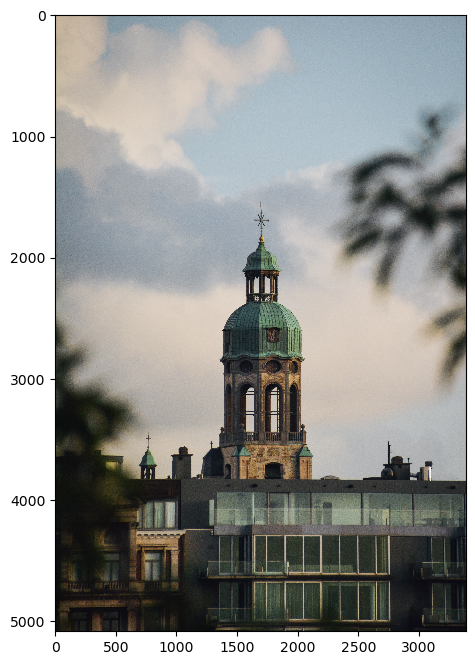

In [28]:
# Generate an caption from the image
# Important Note - this piece of code may not work for all implementations. You may need to adjust it a bit so it
# will produce the desired output (image + caption)
feature = conv(image_tensor)
sampled_ids = lstm.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

# Print out the image and the generated caption
print(sentence)
image = Image.open(image_path)
plt.imshow(np.asarray(image));

## Questions

##**Question:**
Could you think of scenarios where the model fails? Why would that happen? **(10 Points)**

We encourage you to test it on different images (jpg).

**Your answer:**

Scenarios Where the Model Can Fail:

**Complex Scenes**: Images that contain multiple objects or scenes characterized by intricate "object relationships" can pose a challenge. The model may struggle to accurately interpret and describe the complex interactions or the multitude of elements present in such scenes.

**Data Representation**: If the given image significantly differs in quality (e.g., low-resolution, blurry, or poorly lit images) from the data used in pre-training the ResNet model, the model might not caption the image well. The discrepancy in data representation can lead to a loss of detail necessary for accurate caption generation.

**Rare Objects**: Objects that were rare or unseen in the dataset used to pre-train the models (both ResNet and LSTM) can lead to inaccurate captions. The model's ability to recognize and describe these objects is limited by its exposure to them during training, potentially resulting in generic or incorrect captions for images featuring uncommon objects.

### Examples:

In the following examples, I will demonstrate three kinds of images (as explaibed above) that can cause the model to fail, meaning generate a wrong caption.


##### **Complex scene**

In [21]:
# Prepare an image
image_path_complex = os.path.join('data', 'complex.jpg')
image_complex = load_image(image_path_complex, transform)
image_complex_tensor = image_complex.to(device)

<start> a room with a table and a table with a laptop . <end>


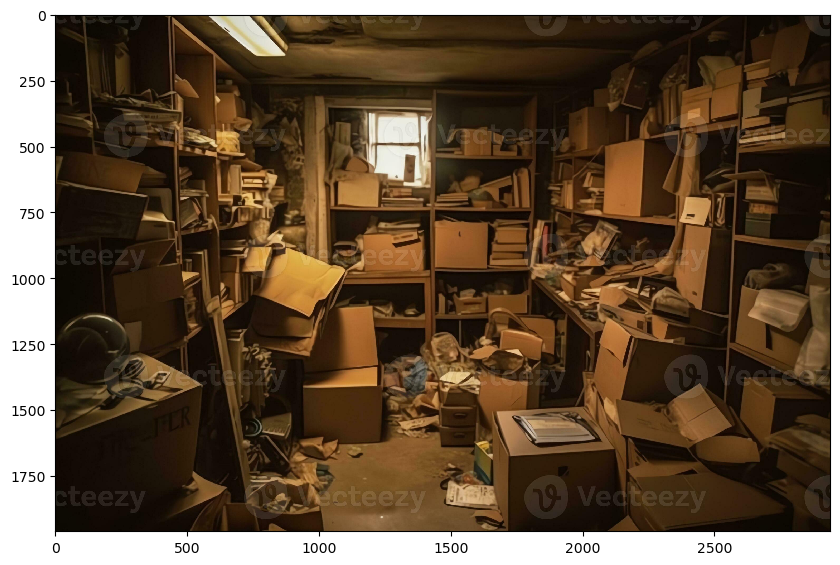

In [27]:
# Generate an caption from the image
# Important Note - this piece of code may not work for all implementations. You may need to adjust it a bit so it
# will produce the desired output (image + caption)
feature = conv(image_complex_tensor)
sampled_ids = lstm.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

# Print out the image and the generated caption
print(sentence)
image_complex = Image.open(image_path_complex)
plt.imshow(np.asarray(image_complex));

In [23]:
# Prepare an image
image_path_poor = os.path.join('data', 'poor_quality.jpg')
image_poor = load_image(image_path_poor, transform)
image_poor_tensor = image_poor.to(device)

##### **Poor quality image**

<start> a group of people walking on a beach with a large clock . <end>


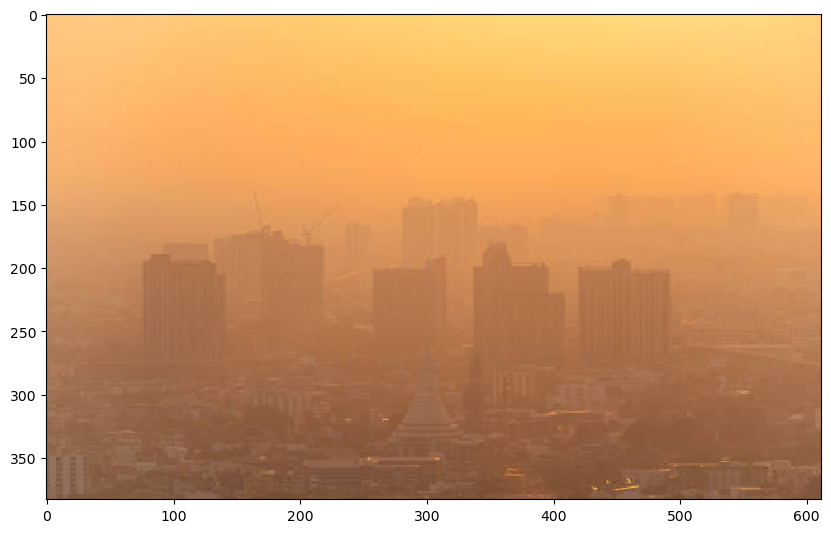

In [24]:
# Generate an caption from the image
# Important Note - this piece of code may not work for all implementations. You may need to adjust it a bit so it
# will produce the desired output (image + caption)
feature = conv(image_poor_tensor)
sampled_ids = lstm.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

# Print out the image and the generated caption
print(sentence)
image_poor = Image.open(image_path_poor)

# corrected_image = image_complex.rotate(-90)

plt.imshow(np.asarray(image_poor));

##### **Unseen objects**

In [25]:
# Prepare an image
image_path_unseen = os.path.join('data', 'unseen.jpg')
image_unseen = load_image(image_path_unseen, transform)
image_unseen_tensor = image_unseen.to(device)

<start> a pile of luggage sitting on a wooden table . <end>


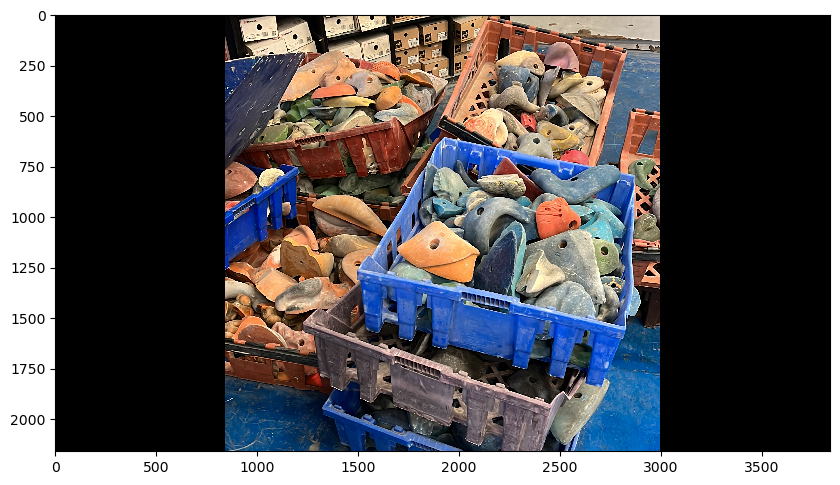

In [26]:
# Generate an caption from the image
# Important Note - this piece of code may not work for all implementations. You may need to adjust it a bit so it
# will produce the desired output (image + caption)
feature = conv(image_unseen_tensor)
sampled_ids = lstm.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

# Print out the image and the generated caption
print(sentence)
image_unseen = Image.open(image_path_unseen)

corrected_image = image_unseen.rotate(-90)

plt.imshow(np.asarray(corrected_image));